# Introduction:
In this notebook, we aim to predict **Formula 1 race positions** using **historical data**. By merging multiple datasets on races, drivers, constructors, and circuits, we will **prepare, train,** and **evaluate machine learning models** to uncover patterns in race outcomes.

#### **Import the following Libraries:**
1. os: for interacting with the operating system
1. Numpy: for numerical computing
2. Pandas: for data manipulation & analysis
3. Matplotlib: for data visualization
4. Tensorflow: for large scale machine learning tasks
5. Keras: for simplifying building & traing the neural network
6. sklearn: used for machine-learning tasks
7. PIL: for image processing 

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
import xgboost as xgb

# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

_In this section, we load the essential datasets required for our analysis using the pandas library. The datasets contain historical Formula 1 data, which we'll use to predict race positions._

#### **Datasets Loaded:**
1. **drivers.csv:** Contains information about drivers.
2. **constructors.csv:** Contains information about constructors (teams).
3. **races.csv:** Details of each race event.
4. **results.csv:** Race results for each driver in each race.
5. **qualifying.csv:** Qualifying results for each driver.
6. **circuits.csv:** Information about the circuits where races are held.

In [3]:
# Load datasets
drivers = pd.read_csv('drivers.csv')
constructors = pd.read_csv('constructors.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
qualifying = pd.read_csv('qualifying.csv')
circuits = pd.read_csv('circuits.csv')

_In this section, we merge the various datasets to create a comprehensive dataset for analysis and perform initial data cleaning steps._

#### **Data Merging:**

1. **Merge results with races:** Adds race details like year, round, and circuitId to the results dataframe.
2. **Merge with drivers:** Incorporates driver details such as driverRef (a reference identifier) and nationality.
3. **Merge with constructors:** Adds constructor (team) names to the dataset.
4. **Merge with circuits:** Includes circuit information like name, location, and country. We use suffixes to distinguish between columns with the same name from different tables.

#### **Data Cleaning:**

**Preview Merged Dataset:** Use results.head() to display the first few rows and verify the merges.

**Check for Missing Values:** Identify any missing data that might affect analysis using results.isnull().sum().

**Handle Missing position Values:**
1. Remove rows where 'position' is missing since it's our target variable.
2. Convert the 'position' column to numeric, coercing non-numeric values (like '\\N') to NaN.
3. Drop rows with NaN in 'position'.
4. Convert the cleaned 'position' column to integer type.

In [4]:
# Merge results with races
results = results.merge(races[['raceId', 'year', 'round', 'circuitId']], on='raceId', how='left')

# Merge with drivers
results = results.merge(drivers[['driverId', 'driverRef', 'nationality']], on='driverId', how='left')

# Merge with constructors
results = results.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')

# Merge with circuits
results = results.merge(circuits[['circuitId', 'name', 'location', 'country']], on='circuitId', how='left', suffixes=('_constructor', '_circuit'))

# Preview the merged dataset
results.head()

# Check for missing values
results.isnull().sum()

# Since we're predicting 'position', remove rows with missing positions
results = results[results['position'].notna()]

# Convert 'position' to numeric
# Replace '\\N' and other non-numeric values with NaN
results['position'] = pd.to_numeric(results['position'], errors='coerce')

# Drop rows with NaN in 'position'
results = results.dropna(subset=['position'])

# Convert 'position' to integer
results['position'] = results['position'].astype(int)


_Here, we prepare the data for modeling by selecting relevant features, encoding categorical variables, and scaling the features._

#### **Feature Selection:**

**Selected features that may influence race outcomes:**
1. 'year', 'round': Temporal features of the race.
2. 'driverRef', 'nationality': Driver-specific information.
3. 'name_constructor': Team information, renamed to 'constructorName'.
4. 'grid': The starting position on the grid.
5. 'positionOrder': The finishing position, renamed to 'position' (our target variable).
6. 'points', 'laps': Performance metrics.
7. 'statusId': Indicates the race status of the driver.

**Important Note on Data Leakage:**

_Caution:_ Including 'positionOrder' and possibly 'points' and 'laps' as features may lead to data leakage since they are outcomes of the race, not inputs known beforehand. This could artificially inflate model performance.

#### **Data Preparation:**

**Create New DataFrame:** data contains only the selected features.

**Rename Columns:** For clarity, 'name_constructor' to 'constructorName' and 'positionOrder' to 'position'.

**Encode Categorical Variables:**
Use LabelEncoder to transform 'driverRef', 'nationality', and 'constructorName' into numeric values.
Define Features and Target Variable:
X: Feature matrix (all columns except 'position').
y: Target vector ('position').

**Feature Scaling:**
Apply MinMaxScaler to scale features between 0 and 1, which helps improve the model's convergence during training.

In [5]:
# Select features
features = ['year', 'round', 'driverRef', 'nationality', 'name_constructor', 'grid', 'positionOrder', 'points', 'laps', 'statusId']

# Create a new dataframe with selected features
data = results[features]

# Rename columns for clarity
data.rename(columns={'name_constructor': 'constructorName', 'positionOrder': 'position'}, inplace=True)

# Encode 'driverRef', 'nationality', and 'constructorName'
label_encoders = {}

for column in ['driverRef', 'nationality', 'constructorName']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target variable
X = data.drop(['position'], axis=1)
y = data['position']

# Use MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

_Splitting our data into training & testing sets_

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

_We define our initial neural network model using Keras' Sequential API._

#### Model Architecture:

**Input Layer:** Specifies the input shape based on the number of features.

**First Hidden Layer:**

Dense layer with 64 neurons and ReLU activation.
Dropout layer with a rate of 0.2 to prevent overfitting.

**Second Hidden Layer:**

Dense layer with 32 neurons and ReLU activation.

**Output Layer:**

Dense layer with 1 neuron (since it's a regression problem predicting a continuous value).

_This model serves as a baseline to compare with more complex architectures._

In [10]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

_We compile, train, and evaluate the initial neural network model._

#### **Compile the Model:**

**Loss Function:** 'mean_squared_error' suitable for regression tasks.

**Optimizer:** 'adam' optimizer for efficient gradient descent.

#### **Train the Model:**

Train for 50 epochs with a batch size of 32.
Use a 10% validation split to monitor the model's performance on unseen data during training.

#### **Predict and Evaluate:**

Make predictions on the test set.

#### **Calculate evaluation metrics:**

**Mean Squared Error (MSE):** Measures the average squared difference between predicted and actual values.

**R² Score:** Indicates the proportion of variance in the dependent variable predictable from the independent variables.


In [11]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 37.9227 - val_loss: 8.3339
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2710 - val_loss: 6.4967
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9290 - val_loss: 5.8425
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0311 - val_loss: 5.1150
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5440 - val_loss: 4.6386
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3392 - val_loss: 4.4798
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2303 - val_loss: 4.4246
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9462 - val_loss: 4.1001
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8410 - val_loss: 4.0222
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6666 - val_loss: 3.9395
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6260 - val_loss: 3.8709
Epoch 12/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

_We plot the training and validation loss over epochs to assess the model's learning behavior._

#### Plot Loss Curves:
Visualize how the loss decreases over time for both training and validation sets.
Helps identify issues like overfitting (validation loss starts increasing while training loss continues to decrease).

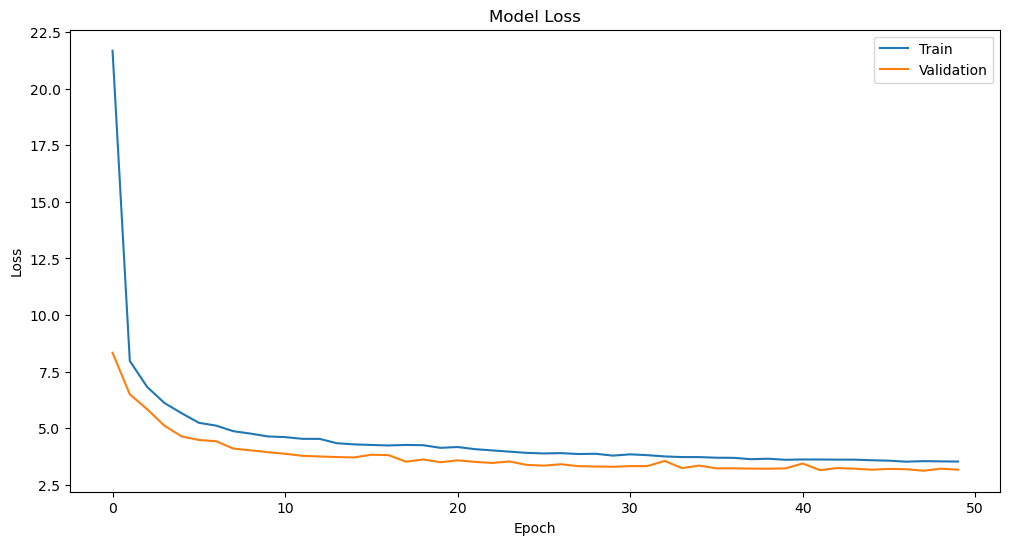

In [12]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

_We experiment with a deeper neural network to see if increasing the model's complexity improves performance._

#### Model Architecture:

**First Hidden Layer:**
Dense layer with 128 neurons and ReLU activation.
Dropout layer with a rate of 0.3.

**Second Hidden Layer:**
Dense layer with 64 neurons and ReLU activation.
Dropout layer with a rate of 0.3.

**Third Hidden Layer:**
Dense layer with 32 neurons and ReLU activation.

**Output Layer:**
Dense layer with 1 neuron for regression output.

_Compile, Train, and Evaluate:Use the same loss function and optimizer. Train the model and evaluate its performance using MSE and R² Score._

In [8]:
model2 = Sequential()
model2.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1))  # Output layer for regression

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict on test data
y_pred = model2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 33.0261 - val_loss: 6.9709
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0332 - val_loss: 5.8201
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7263 - val_loss: 5.0239
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.0801 - val_loss: 4.3851
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9082 - val_loss: 4.6698
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7489 - val_loss: 4.7785
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1388 - val_loss: 3.9926
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.0081 - val_loss: 4.1947
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0419 - val_loss: 4.0067
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8456 - val_loss: 3.7374
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8228 - val_loss: 3.6533
Epoch 12/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

_Here, we test a model with more neurons per layer to increase its capacity._

#### Model Architecture:

**First Hidden Layer:**
Dense layer with 256 neurons and ReLU activation.
Dropout layer with a rate of 0.4.

**Second Hidden Layer:**
Dense layer with 256 neurons and ReLU activation.
Dropout layer with a rate of 0.4.

**Output Layer:**
Dense layer with 1 neuron for regression output.
Compile, Train, and Evaluate:
Same compilation and evaluation process as before.

#### Purpose:
To determine if a wider network captures more complex patterns in the data.

In [ ]:
# Wider Neural Network
model3 = Sequential()
model3.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(1))  # Output layer for regression

# Compile the model
model3.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict on test data
y_pred = model3.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 27.1847 - val_loss: 6.4636
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0470 - val_loss: 5.1167
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.2149 - val_loss: 4.6301
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8450 - val_loss: 4.2314
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2806 - val_loss: 4.2616
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2281 - val_loss: 3.9287
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1175 - val_loss: 3.8183
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7787 - val_loss: 3.8580
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9273 - val_loss: 3.6755
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.9713 - val_loss: 3.8045
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6582 - val_loss: 3.5780
Epoch 12/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

_We modify the activation functions to see if it enhances model performance._

#### Model Architecture:

**First Hidden Layer:**
Dense layer with 64 neurons.
LeakyReLU activation function (alpha=0.1) to address the "dying ReLU" problem.
Dropout layer with a rate of 0.2.

**Second Hidden Layer:**
Dense layer with 32 neurons.
LeakyReLU activation function.

**Output Layer:**
Dense layer with 1 neuron for regression output.
Compile, Train, and Evaluate:
Use the same process as previous models.

#### Purpose:
To test whether alternative activation functions can improve learning.

In [11]:
# Different activation function
model4 = Sequential()
model4.add(Dense(64, input_dim=X_train.shape[1]))
model4.add(LeakyReLU(alpha=0.1))
model4.add(Dropout(0.2))
model4.add(Dense(32))
model4.add(LeakyReLU(alpha=0.1))
model4.add(Dense(1))  # Output layer for regression

# Compile the model
model4.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model4.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict on test data
y_pred = model4.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 37.7555 - val_loss: 8.7011
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4462 - val_loss: 6.7800
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2751 - val_loss: 6.2092
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 6.6182 - val_loss: 5.7736
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4060 - val_loss: 5.4712
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 6.0493 - val_loss: 5.1712
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5348 - val_loss: 5.0648
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8914 - val_loss: 4.7724
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 5.3660 - val_loss: 4.5738
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2072 - val_loss: 4.4757
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 4.8799 - val_loss: 4.3263
Epoch 12/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s

_We incorporate batch normalization layers to improve training stability and speed._

#### Model Architecture:

**First Hidden Layer:**
Dense layer with 128 neurons.
BatchNormalization layer to normalize inputs.
LeakyReLU activation function.
Dropout layer with a rate of 0.3.

**Second Hidden Layer:**
Dense layer with 64 neurons.
BatchNormalization layer.
LeakyReLU activation function.

**Output Layer:**
Dense layer with 1 neuron for regression output.
Compile, Train, and Evaluate:
Follow the same procedure as before.
 
##### Purpose:
To see if batch normalization can enhance performance by reducing internal covariate shift.

In [13]:
#Add Batch Normalization

model5 = Sequential()
model5.add(Dense(128, input_dim=X_train.shape[1]))
model5.add(BatchNormalization())
model5.add(LeakyReLU(alpha=0.1))
model5.add(Dropout(0.3))
model5.add(Dense(64))
model5.add(BatchNormalization())
model5.add(LeakyReLU(alpha=0.1))
model5.add(Dense(1))

# Compile the model
model5.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model5.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Predict on test data
y_pred = model5.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 45.7853 - val_loss: 12.5251
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.5812 - val_loss: 4.5752
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.9663 - val_loss: 4.3941
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8837 - val_loss: 4.0560
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5481 - val_loss: 4.0406
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6727 - val_loss: 4.0076
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5474 - val_loss: 3.9125
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0747 - val_loss: 4.0111
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0703 - val_loss: 3.7179
Epoch 10/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8531 - val_loss: 3.7027
Epoch 11/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.0513 - val_loss: 3.8344
Epoch 12/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

_We shift from neural networks to tree-based ensemble methods by implementing an XGBoost regressor._

#### Model Definition:
**Use XGBRegressor with:**
n_estimators=100: Number of gradient boosted trees.
learning_rate=0.1: Step size shrinkage.
max_depth=6: Maximum depth of a tree.
random_state=42: For reproducibility.

**Train the Model:**
Fit the model on the training data.
Predict and Evaluate:
Make predictions on the test set.
Evaluate using MSE and R² Score.

**Purpose:**
To compare the performance of advanced ensemble methods with neural networks on this dataset.

In [8]:
# XGBoost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 2.4488515357083847
R^2 Score: 0.895202203742742


#### Conclusion - XGBoost Outperforms Other Models
After experimenting with various models, we conclude that the _XGBoost regressor_ delivers the best performance.

**Performance Comparison:**
_XGBoost_ achieved the lowest Mean Squared Error and the highest R² Score among all tested models.
_Neural network models_, despite architectural changes, did not outperform _XGBoost_.

**Final Result:**
_XGBoost_ is the best model for predicting race positions in this dataset.

**Implications:**
Tree-based ensemble methods like _XGBoost_ can be more effective for tabular data with complex relationships.
